# InSAR Time Series Analysis using MintPy and ARIA products

**Author:** David Bekaert, Heresh Fattahi and Zhang Yunjun 

 This notebook is a modification from the [original](https://nbviewer.jupyter.org/github/insarlab/MintPy-tutorial/blob/master/smallbaselineApp_aria.ipynb) by Heresh Fattahi and Zhang Yunjun. 


**Target NISAR Solid Earth Science Team**

The ARIA in partnership with GRFN project has been generated surface displacement products mimicking the NISAR L2 GUNW product formatting. The Miami Insar Timeseries software in PYthon (MintPy), an open-source package for InSAR time-series analysis, is compatible with the outputs from the ARIA-tools package, and in combination with the ARIA-tools pre-processor can be used to estimate ground displacement time-series. 

The Jupuyter notebook presented here is meant as an practical example on the use of Jypter for implementing the L2 science requirement for secular displacements. In the example below, we will demonstrate a time-series derived from ARIA standard InSAR products over the San Francisco revealing interseimic fault motion, and with a first order visual comparison to local GNSS stations. 




**Users running this notebook can enter it at two differnt locations:**

##### 1) The user is starting this notebook from data-download.

Using the command line interface, users should have ran within the *L2_interseismic* folder:

`ariaDownload.py -b '37.25 38.1 -122.6 -121.75' --track 42`

`ariaTSsetup.py -f 'products/*.nc' -b '37.25 38.1 -122.6 -121.75' --mask Download`

and within the *L2_interseismic/mintpySF* folder:

`smallbaselineApp.py SanFranSenDT42.txt --dostep load_data`

The rest of the notebook can be ran as normal

##### 2) The user is leveraging pre-staged input data for MintPy 

This option is only available for open-sar-lab users, other users should default back to option 1). The staged data is uploaded in the S3 data bucket of openSARlab and will be downloaded by modifying the python cell within in **Section 0. Notebook Setup** to: 

`Use_Staged_Data = True`


# 0. Notebook setup

The cell below is required to be ran each time the notebook is started and ensures correct set-up of the notebook.

In [1]:
# option to control the use of pre-staged data; [False/True]
Use_Staged_Data = False

# ------------------------------------------------------------------------------------------- #

# no changed below needed:
import os

# define the work directory
work_dir = os.path.abspath(os.getcwd())
print("Work directory: ", work_dir)
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
    print('Create directory: {}'.format(work_dir))
print('Go to work directory: {}'.format(work_dir))
os.chdir(work_dir)  


if Use_Staged_Data:
    # Check if a stage file from S3 already exist, if not try and download it
    if not os.path.isfile('NISARtraining_inputSFmintpy.zip'):
        !aws s3 cp s3://asf-jupyter-data/NISARtraining_inputSFmintpy.zip NISARtraining_inputSFmintpy.zip

    # verify if download was succesfull
    if os.path.isfile('NISARtraining_inputSFmintpy.zip'):
        !unzip NISARtraining_inputSFmintpy.zip
        print('S3 pre-staged data retrieval was successfull')
    else:
        print("Download outside openSarLabs is not supported.\nAs alternative please start from ARIA-tools with the commandline calls provided at the top of this notebook")          
else:
    print("Will not be using S3 pre-staged data, users has pre-processed data manually")

# verify if mintpy install is complete:
try:
    import numpy as np
    from mintpy.cli import view, tsview, plot_network, plot_transection, plot_coherence_matrix
except:
    print("Looks like mintPy is not fully installed")


Work directory:  /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF
Go to work directory: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF
Will not be using S3 pre-staged data, users has pre-processed data manually


# 1. smallbaselineApp.py overview

This application provides a workflow which includes several steps to invert a stack of unwrapped interferograms and apply different corrections to obtain ground displacement timeseries.  
The workflow consists of two main blocks:

* correcting unwrapping errors and inverting for the raw phase time-series (blue ovals),
* correcting for noise from different sources to obtain the displacement time-series (green ovals).

Some steps are optional, which are switched off by default (marked by dashed boundaries). Configuration parameters for each step are initiated with default values in a customizable text file: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg). In this notebook, we will walk through some of these steps, for a complete example see the [MintPy repository](https://github.com/insarlab/MintPy).

<p align="left">
  <img width="600" src="docs/smallbaselineApp_workflow.png">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

## 1.1 Processing steps of smallbaselineApp.py

The MintPy **smallbaselineApp.py** application provides a workflow to invert a stack of unwrapped interferograms and apply different (often optional) corrections to obtain ground displacement timeseries. A detailed overview of the options can be retrieved by involking the help option:

In [2]:
!smallbaselineApp.py --help

usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--plot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]

Routine Time Series Analysis for Small Baseline InSAR Stack

positional arguments:
  customTemplateFile    custom template with option settings.
                        ignored if the default smallbaselineApp.cfg is input.

optional arguments:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        work directory, (default: ./).
  -g                    generate default template (if it does not exist) and exit.
  -H                    print the default template file and exit.
  -v, --version         print software version and exit
  --plot                plot results [only] without running smallbaselineApp.

steps processing (start/end/dostep):
  Command line options for steps processing with names are chosen from the following list:
  
  

## 1.2 Configuring processing parameters

The processing parameters for the **smallbaselineApp.py** are controlled through a configuration file. If no file is provided the default [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/master/mintpy/defaults/smallbaselineApp.cfg) configuration is used. Here we use `SanFranSenDT42.txt`, which already constains selective, manually modified configuration parameters.

# 2. Small Baseline Time Series Analysis

## 2.1. Loading ARIA data into MintPy

The [ARIA-tools package](https://github.com/aria-tools/ARIA-tools) is used as a pre-processor for MintPy. It has a download tool that wraps around the ASF DAAC API, and includes tools for stitching/cropping and time-series preparation. The output of the time-series preparation is compatible with the [data directory](https://mintpy.readthedocs.io/en/latest/dir_structure/) structure from MintPy. 

As instructed at the start of this notebook, there are two ways that users can run it. The command used were.

```
!ariaDownload.py -b '37.25 38.1 -122.6 -121.75' --track 42
!ariaTSsetup.py -f 'products/*.nc' -b '37.25 38.1 -122.6 -121.75' --mask Download
!smallbaselineApp.py SanFranSenDT42.txt --dostep load_data
```

The output of the loading step is an "inputs" directory containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata.  
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.). 

In [3]:
!ls inputs

geometryGeo.h5	ifgramStack.h5	SanFranSenDT42.txt  smallbaselineApp.cfg


<div class="alert alert-info">
<b>info.py :</b> 
To get general infomation about a MintPy product, run info.py on the file.   
</div>

In [4]:
!info.py inputs/ifgramStack.h5

******************** Basic File Info ************************
file name: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/inputs/ifgramStack.h5
file type: ifgramStack
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                   7
  ANTENNA_SIDE             -1
  CENTER_LINE_UTC          50864.0
  EARTH_RADIUS             6337286.638938101
  FILE_LENGTH              1020
  FILE_TYPE                ifgramStack
  HEADING                  -168
  HEIGHT                   693000.0
  LAT_REF1                 38.1
  LAT_REF2                 38.1
  LAT_REF3                 37.25
  LAT_REF4                 37.25
  LENGTH                   1020
  LON_REF1                 -122.6
  LON_REF2                 -121.75
  LON_REF3                 -122.6
  LON_REF4                 -121.75
  NUMBER_OF_PAIRS          443
  ORBIT_DIRECTION          DESCENDING
  PLATFORM                 Sen
  PROCESSOR                i

In [5]:
!info.py inputs/geometryGeo.h5

******************** Basic File Info ************************
file name: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/inputs/geometryGeo.h5
file type: geometry
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                   7
  ANTENNA_SIDE             -1
  CENTER_LINE_UTC          50864.0
  EARTH_RADIUS             6337286.638938101
  FILE_LENGTH              1020
  FILE_TYPE                geometry
  HEADING                  -168
  HEIGHT                   693000.0
  LAT_REF1                 38.1
  LAT_REF2                 38.1
  LAT_REF3                 37.25
  LAT_REF4                 37.25
  LENGTH                   1020
  LON_REF1                 -122.6
  LON_REF2                 -121.75
  LON_REF3                 -122.6
  LON_REF4                 -121.75
  NUMBER_OF_PAIRS          443
  ORBIT_DIRECTION          DESCENDING
  PLATFORM                 Sen
  PROCESSOR                isce
  

## 2.2. Plotting the interferogram network

Running **plot_network.py** gives an overview of the network and the average coherence of the stack. The program creates multiple files as follows:
- ifgramStack_coherence_spatialAvg.txt: Contains interferogram dates, average coherence temporal and spatial baseline separation.
- Network.pdf: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms. 
- CoherenceMatrix.pdf shows the avergae coherence pairs between all available pairs in the stack.

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-05-07 18:54:32.123565--
Current directory: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF
obsolete default template detected, update to the latest version.
    mintpy.load.processor: auto --> aria
    mintpy.load.unwFile: auto --> ../stack/unwrapStack.vrt
    mintpy.load.corFile: auto --> ../stack/cohStack.vrt
    mintpy.load.connCompFile: auto --> ../stack/connCompStack.vrt
    mintpy.load.demFile: aut

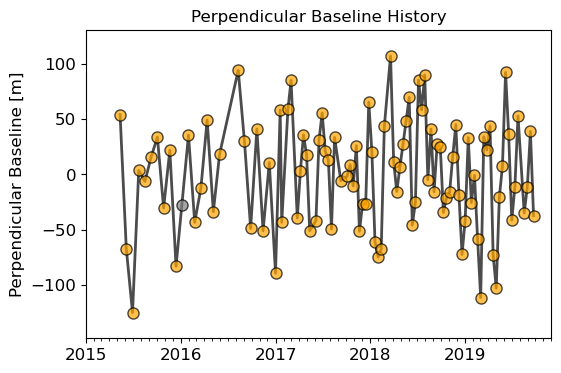

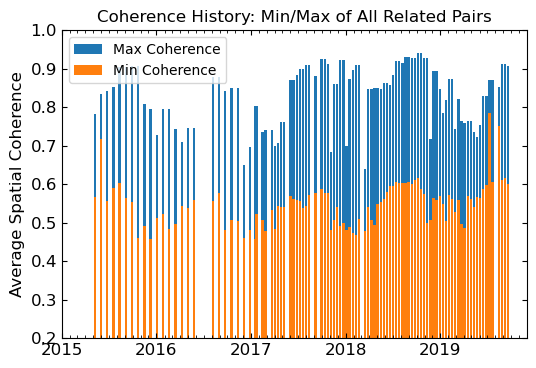

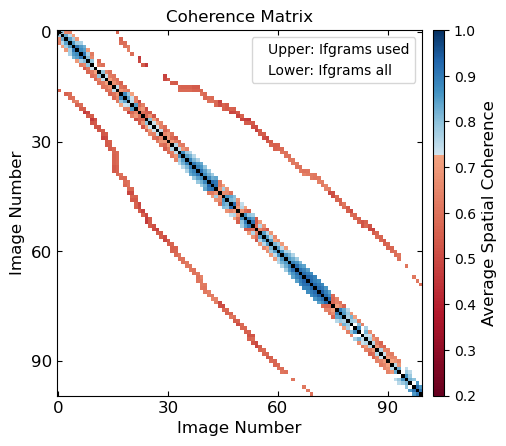

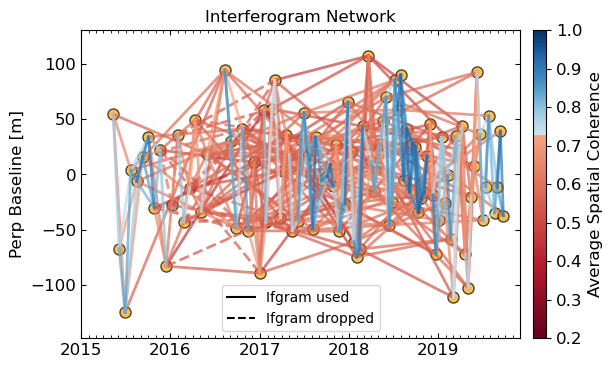

In [6]:
!smallbaselineApp.py SanFranSenDT42.txt  --dostep modify_network
plot_network.main(['inputs/ifgramStack.h5'])

## 2.3.  Mask generation

Mask files can be can be used to mask pixels in the time-series processing. Below we generate a mask file based on the connected components, which is a metric for unwrapping quality.

input ifgramStack file: inputs/ifgramStack.h5
--------------------------------------------------
update mode: ON
1) output file maskConnComp.h5 already exists.
2) output file is newer than input dataset: connectComponent.
run or skip: skip.
run view.py in MintPy version 1.5.3, date 2023-11-23
input file is mask file: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/maskConnComp.h5 in bool format
file size in y/x: (1020, 1020)
num of datasets in file maskConnComp.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']
data   coverage in y/x: (0, 0, 1020, 1020)
subset coverage in y/x: (0, 0, 1020, 1020)
data   coverage in lat/lon: (-122.6, 38.1, -121.75, 37.25)
subset coverage in lat/lon: (-122.6, 38.1, -121.75, 37.25)
------------------------------------------------------------------------
colormap: jet
figure title: maskConnComp
figure size : [7.5, 6.0]
reading data ...
data has uniform and limited number (2 <= 20) of unique values --> discretize colo

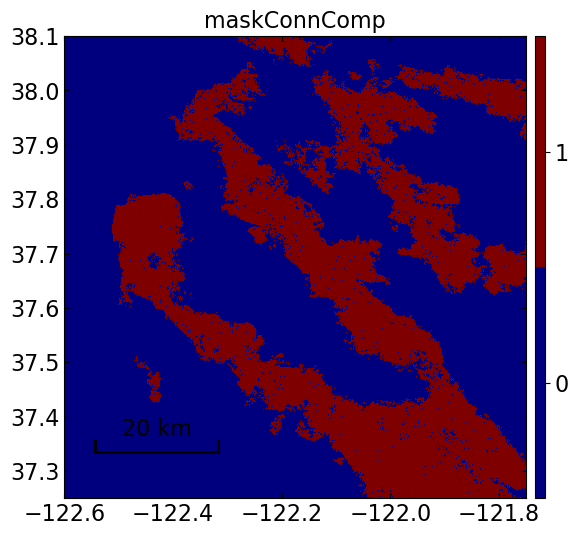

In [7]:
!generate_mask.py  inputs/ifgramStack.h5  --nonzero  -o maskConnComp.h5  --update
view.main(['maskConnComp.h5'])

## 2.4. Inverting of the Small Baseline network

In the next step we invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date. By default mintpy selects the first acquisition. The estimated time-series is converted to distance change from radar to target and is provided in meters. 

In [8]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep reference_point
!smallbaselineApp.py SanFranSenDT42.txt --dostep invert_network

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-05-07 18:54:52.851578--
Current directory: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF
read custom template file: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/SanFranSenDT42.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/smallbaselineApp.cfg
read default template file:

The timeseries file contains three datasets:
- the "time-series" which is the interferometric range change for each acquisition relative to the reference acquisition,
- the "date" dataset which contains the acquisition date for each acquisition,
- the "bperp" dataset which contains the timeseries of the perpendicular baseline.  

## 2.5. Estimating the long-term velocity rate

The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation which is the slope of linear fit to the time-series. 

In [9]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep velocity

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-05-07 18:54:55.936929--
Current directory: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF
read custom template file: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/SanFranSenDT42.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/smallbaselineApp.cfg
read default template file: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/smallbaselineApp.cfg


******************** step - velocity ********************

timeseries2velocity.py /home/jovyan/ARIA-to

run view.py in MintPy version 1.5.3, date 2023-11-23
input file is velocity file: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/velocity.h5 in float32 format
file size in y/x: (1020, 1020)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1020, 1020)
subset coverage in y/x: (0, 0, 1020, 1020)
data   coverage in lat/lon: (-122.6, 38.1, -121.75, 37.25)
subset coverage in lat/lon: (-122.6, 38.1, -121.75, 37.25)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [7.5, 6.0]
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [-1.531406, 1.178216] cm/year
display range: [-1.0, 1.0] cm/year
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image via matplotlib.pyplot.imshow ...
plot scale

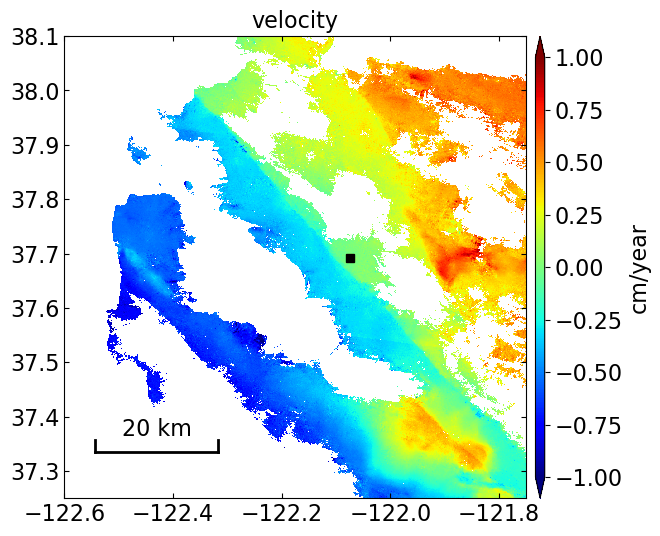

In [10]:
scp_args = 'velocity.h5 velocity -v -1 1'
view.main(scp_args.split())

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation).
</div>

Obvious features in the estimated velocity map:

1) The general pattern of displacement is consistent with tectonic setting of the region. Pacific plate is moving north-west with respect to North american plate. The satellites is on a descending track and the estimated displacement shows the blue region is moving away from the red region. 

2) The magnitude of the relative movement (blue region relative to red region) is about ~15 mm/yr in radar Line-Of-Sight (LOS) direction which is consistent with ~40 mm/yr horizontal movements of pacific relative to north america.

3) The estimated velocity shows a linear feature almost aligned with the south-east north-west diagonal of the map. This linear feature shows the aseismic fault creep on Hayward fault. 

4) Further north and around latitude 38N another linear feature represents Concord fault parallel to Hayward fault.

5) Around latitude 37.9 N, a east-west linear discontinuity is evident. This is most likely caused by missing bursts in some interferograms. 

6) The red region at the south-east corenr (around 37.35 N, 121.9W) seems to be a hydrological signal showing ground uplift caused by acquifer recharge.

7) The block box at 37.7N, 122.3W is the reference pixel for this map. 

## 2.6. Velocity error analysis

The estimated velocity also comes with an expression of unecrtainty which is simply based on the goodness of fit while fitting a linear model to the time-series. This quantity is saved in "velocity.h5" under the velocityStd dataset. 

**Mintpy supports additional corrections in its processing not included in this demo:**
- Unwrapping error correction
- Tropospheric delay correction
- deramping
- Topographic residual correction
- Residual RMS for noise evaluation
- Changing the reference date

run view.py in MintPy version 1.5.3, date 2023-11-23
input file is velocity file: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/velocity.h5 in float32 format
file size in y/x: (1020, 1020)
input dataset: "['velocityStd']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocityStd']
data   coverage in y/x: (0, 0, 1020, 1020)
subset coverage in y/x: (0, 0, 1020, 1020)
data   coverage in lat/lon: (-122.6, 38.1, -121.75, 37.25)
subset coverage in lat/lon: (-122.6, 38.1, -121.75, 37.25)
------------------------------------------------------------------------
colormap: jet
figure title: velocityStd
figure size : [7.5, 6.0]
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [0.0, 0.15828244] cm/year
display range: [0.0, 0.2] cm/year
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image via matplotlib.pyplot.imshow ...
plot s

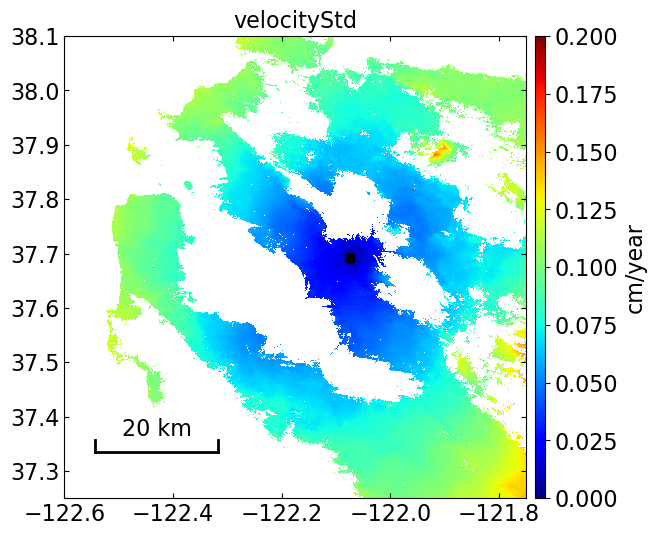

In [11]:
scp_args = 'velocity.h5 velocityStd -v 0 0.2'
view.main(scp_args.split())

# 3. Plotting a Fault Creep Transect 

plot_transection.py velocity.h5 --start-lalo 37.6523 -122.1163 --end-lalo 37.7047 -122.0497
run view.py in MintPy version 1.5.3, date 2023-11-23
input file is velocity file: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/velocity.h5 in float32 format
file size in y/x: (1020, 1020)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1020, 1020)
subset coverage in y/x: (0, 0, 1020, 1020)
data   coverage in lat/lon: (-122.6, 38.1, -121.75, 37.25)
subset coverage in lat/lon: (-122.6, 38.1, -121.75, 37.25)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [7.5, 6.0]
read mask from file: maskTempCoh.h5
data    range: [-1.531406, 1.178216] cm/year
display range: [-1.531406, 1.178216] cm/year
figure size : [7.5, 6.0]
display data in transparen

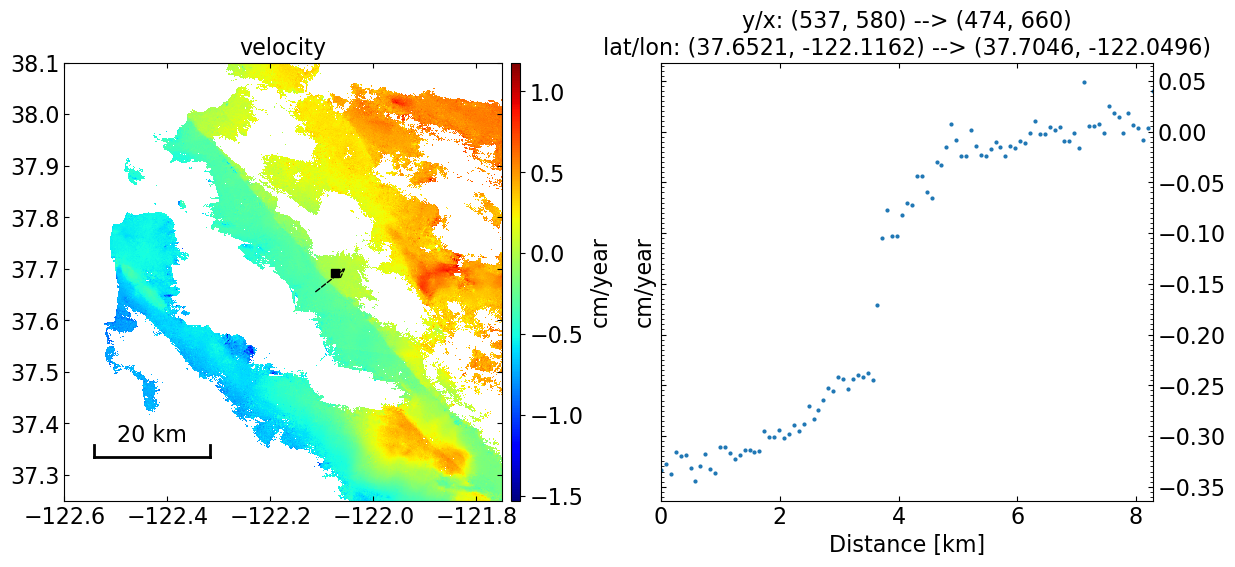

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-05-07 18:54:59.133073--
Current directory: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF
Run routine processing with smallbaselineApp.py on steps: ['google_earth']
Remaining steps: ['hdfeos5']
--------------------------------------------------
Go to work directory: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF
read default template file: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/smallbaselineApp.cfg


******************** step - google_earth ********************
creating Google Earth KMZ file for geocoded velocity file: ...

save_kmz.py /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/velocity.h5 -o /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/velocity.kmz
['velocity.kmz'] exists and is newer than ['/home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/velocity.h5'] --> skip.
Go back to 

In [12]:
scp_args = 'velocity.h5 --start-lalo 37.5307 -122.3631 --end-lalo 37.9828 -121.7707 '
scp_args = 'velocity.h5 --start-lalo 37.6523 -122.1163 --end-lalo 37.7047 -122.0497 '
plot_transection.main(scp_args.split())

!smallbaselineApp.py smallbaselineApp.cfg --dostep google_earth

The transect across Hayward fault shows ~2.5 mm/yr fault creep in LOS direction.

# 4. Validating InSAR with GPS

MintPy can automatically download GPS data over the region of interest from Nevada Geodetic Laboratory at University of Nevada, Reno. 

Thew following command plots add dowloads GPS data, project the components to InSAR LOS direction and plot them on the InSAR velocity map:   

run view.py in MintPy version 1.5.3, date 2023-11-23
input file is velocity file: /home/jovyan/ARIA-tools-docs/JupyterDocs/NISAR/L2_interseismic/mintpySF/velocity.h5 in float32 format
file size in y/x: (1020, 1020)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1020, 1020)
subset coverage in y/x: (0, 0, 1020, 1020)
data   coverage in lat/lon: (-122.6, 38.1, -121.75, 37.25)
subset coverage in lat/lon: (-122.6, 38.1, -121.75, 37.25)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [7.5, 6.0]
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [-1.531406, 1.178216] cm/year
display range: [-1.531406, 1.178216] cm/year
display data in transparency: 1.0
plot in geo-coordinate
referencing InSAR data to the pixel nearest to GNSS stat

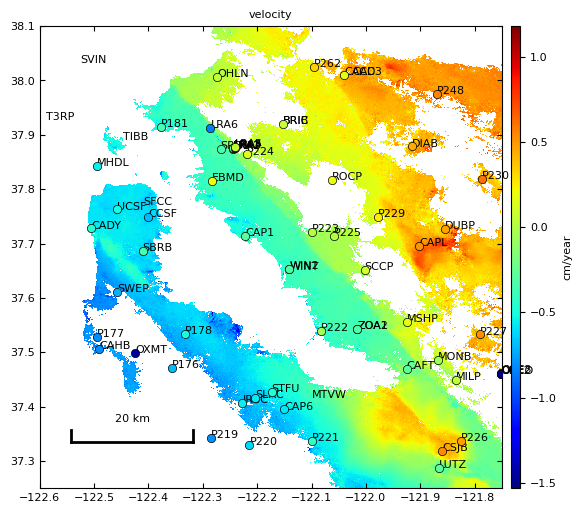

In [13]:
scp_args = 'velocity.h5 velocity --show-gps --ref-gps P225 --gps-comp enu2los --gps-label --fontsize 8'
view.main(scp_args.split())

# Reference material

- Original Notebook withe detailed description by Yunjun and Fattahi at: https://nbviewer.jupyter.org/github/insarlab/MintPy-tutorial/blob/master/smallbaselineApp_aria.ipynb

- Mintpy reference: *Yunjun, Z., H. Fattahi, F. Amelung (2019), Small baseline InSAR time series analysis: unwrapping error correction and noise reduction, preprint doi:[10.31223/osf.io/9sz6m](https://eartharxiv.org/9sz6m/).*

- University of Miami online time-series viewer: https://insarmaps.miami.edu/

- Mintpy Github repository: https://github.com/insarlab/MintPy

- ARIA-tools Github Repository: https://github.com/aria-tools/ARIA-tools